# Executive Summary

**Background Problem**
This report explores a predictive model designed to estimate individuals' initial interest in long-term gym subscriptions for an internationally recognized gym chain aims at targeting Polish market with the 
establishment of three new premise.  By analysing personal data—such as name, date of birth, place of residence, hobbies, and occupation—the study aims to uncover insights that can inform marketing strategies and improve customer acquisition efforts.

**Range of Investigation**
The analysis uses a diverse dataset containing personal attributes from potential gym subscribers. It focuses on identifying patterns and correlations that may indicate a likelihood of gym subscription, ultimately guiding targeted marketing initiatives.

**Methods of Analysis**
The investigation employed exploratory data analysis (EDA), feature engineering, and predictive modeling techniques. EDA involved visualisations and statistical assessments to reveal relationships within the data. Feature engineering transformed hobbies into binary variables, resulting in 175 new features. K-means clustering was used to summarise hobbies into broader categories, enhancing the model's interpretability. Three models were employed to predict interest in gym subscriptions for new clients, including a simple Logistic Regressio and two gradient boosting algorithms, LightGBM and XGBoostt, along with feature selection.

**Findings**
The most effective model, LightGBM, achieved a recall of 0.75 for the target value of interest (positive interest), indicating that 75% of interested individuals were accurately identified.Significant patterns were discovered, linking specific personal attributes—such as the number of friends, relationship status, gender, daily commute distance, age, area population size, and personal interests—to a higher likelihood of subscription interest.  Performance could be enhanced through hyperparameter optimisation, cross-validation, and improved natural language processing techniques for exploring hobbies more effectively.

**Conclusions and Recommendations**
The predictive model demonstrates potential for identifying individuals likely to subscribe to a gym based on their personal data. Key factors include the number of friends, relationship status, gender, daily commute distance, age, population size of their area, and interests.

The analysis indicates that the most interested individuals tend to be aged 20-30, single or in a relationship but not married, primarily male, and residing in cities with populations over 50,000. Those with around 200 friends are particularly likely to show interest.

To effectively attract these potential customers, new gym facilities should be promoted primarily to these groups, as they may require less persuasion to sign up. In contrast, other demographics may need more targeted advertising to generate interest in memberships.

# Data Input and Transformations


In this section, I am importing the dataset from both CSV and JSON files, merging them, and performing all necessary data cleaning, preprocessing, and basic exploratory data analysis (EDA) to understand the data better. 

Firstly, I check the dataset for duplicates and missing values. While no duplicates are found, there are several features with missing values. Given the dataset's size (4000 rows), it would be inefficient to remove data points with missing values entirely. Moreover, the features affected are expected to be important for the target variable and thus cannot be removed either. The positions of the missing values were found not to affect the target variable or correlate with each other, leading to the assumption that they are random. 

To handle the missing values, I have temporarily replaced them with placeholder values: 
- `-999` for numerical features
- `'missing'` for categorical features

Additionally, the `Date of Birth` feature was transformed into `Age` to reduce the wide range of values. The `Hobbies` feature, which was initially a string containing several values, was one-hot encoded, resulting in each individual hobby forming a new binary feature. While this significantly increases dimensionality (by approximately 200), the aim is to preserve as much information as possible and later select only a few features that have the most substantial influence on the target variable.

Next, prior to label encoding the categorical variables, I performed exploratory data analysis to gain a better understanding of the data before modeling. Additionally, the training dataset is further split into training and validation sets to avoid data leakage.


In [396]:
# Importing libraries

import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from IPython.display import display, Markdown

import geopandas as gpd
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

## Data Import

In [2]:
# Importing files functions
def load_json(filename):
    """
    Load user group data from a JSON file and transform it into a pandas DataFrame.
    
    Args:
        filename (str): Path to the JSON file.
        
    Returns:
        DataFrame: A DataFrame with 'user_id', 'group_names', and 'date_joined' columns.
    """
    with open(filename, encoding='utf-8') as file:
        data_json = json.load(file)

    # Create a list to store each user's groups data
    user_groups_list = []
    
    # Parse JSON data to extract relevant information
    for item in data_json['data']:
        user_id = int(item['id'])  # Extract user_id
        groups_data = item['groups']['data']  # Extract groups data

        # Initialize a dictionary to store user groups information
        user_groups = {'user_id': user_id}
        for group in groups_data:
            user_groups.setdefault('group_names', []).append(group['group_name'])
            user_groups.setdefault('date_joined', []).append(group['date_joined'])

        user_groups_list.append(user_groups)  # Add the user data to the list

    # Convert the list of dictionaries to a pandas DataFrame
    groups_df = pd.DataFrame(user_groups_list)
    return groups_df

# Function to merge the CSV DataFrame with the JSON DataFrame on 'user_id'
def merge_groups(user_data_df, group_data_df):
    """
    Merge user data from a CSV DataFrame with group data from a JSON DataFrame on 'user_id'.
    
    Args:
        user_data_df (DataFrame): DataFrame containing user data (from CSV).
        group_data_df (DataFrame): DataFrame containing user group data (from JSON).
        
    Returns:
        DataFrame: Merged DataFrame combining user data and group data.
    """
    merged_df = pd.merge(user_data_df, group_data_df, on='user_id', how='left')
    return merged_df

# Function to add JSON group data to a CSV DataFrame
def add_json(user_data_df, json_filename):
    """
    Add group information from a JSON file to a user data DataFrame.
    
    Args:
        user_data_df (DataFrame): DataFrame containing user data (from CSV).
        json_filename (str): Path to the JSON file containing group data.
        
    Returns:
        DataFrame: Updated DataFrame containing user data and group information.
    """
    # Load the JSON data as a DataFrame
    group_data_df = load_json(json_filename)
    
    # Merge the CSV data with the JSON data
    updated_user_data_df = merge_groups(user_data_df, group_data_df)
    
    return updated_user_data_df

In [397]:
# Importing files

# Import CSV files with train and test data
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

# Import and merge the JSON data
train_df = add_json(train_csv, 'train.json')
test_df = add_json(test_csv, 'test.json')

In [398]:
# Taking a first look at the data structure
display(Markdown("### Taking a First Look at the Data Structure and Example Values:"))
train_df.head()

### Taking a First Look at the Data Structure and Example Values:

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type,group_names,date_joined
0,0,1,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.00,196,Single,NaN,Visa,[Let's excercise together and lose a few kilo ...,"[2008-09-05 09:55:18.730066, 2008-05-22 21:25:..."
1,1,0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.00,243,Single,NaN,NaN,"[Tom Cruise group, Babysitters (Sokółka), Work...","[2009-06-14 16:48:28.606142, 2010-09-25 03:21:..."
2,2,1,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.00,191,In relationship,3.00,NaN,"[Polish wildlife - best places, Politics and p...","[2007-07-29 18:15:49.603727, 2010-10-03 21:00:..."
3,3,0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.00,164,In relationship,3.00,Visa,"[The Aspiring Writer, Nutrition & food advices...","[2009-09-08 15:49:57.132171, 2010-12-02 18:19:..."
4,4,0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.00,119,Married with kids,5.00,NaN,"[The ultimate house and electro group, Pirates...","[2008-01-02 14:57:39.269135, 2012-03-05 03:28:..."


## Data preprocessing

### Duplicates

In [5]:
# Check for duplicated based on user_id
if not train_df.duplicated(['user_id']).any():
    print("No potential duplicates found based on User ID.")

No potential duplicates found based on User ID.


In [6]:
# Check for potential duplicates based on the combination of name, date of birth, location and occupation.
# While this doesn't guarantee the same person, the likelihood of multiple individuals sharing 
# the same name, birthdate, occupation and city is low. Any positive results would warrant further investigation 
# using additional features.

if not train_df.duplicated(subset=["name", "dob", "location", 'occupation']).any():
    print("No potential duplicates found based on name, date of birth, location and occupation.")
else:
    # Find and display the duplicate rows if they exist
    duplicates = train_df[train_df.duplicated(subset=["name", "dob", "location", 'occupation'], keep=False)]
    print("Duplicate entries found based on name, date of birth, location and occupation:")
    print(duplicates)

No potential duplicates found based on name, date of birth, location and occupation.


### Missing values

In [7]:
# Check for missing values in the DataFrame and display the count of null values for each column
missing_values_count = train_df.isnull().sum()

# Create a DataFrame with a single row
missing_values_df = pd.DataFrame([missing_values_count.values], columns=missing_values_count.index)

# Set the index name for clarity
missing_values_df.index = ['Missing Values Count']

missing_values_df

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type,group_names,date_joined
Missing Values Count,0,0,18,384,394,0,0,0,0,0,680,405,0,393,408,428,56,56


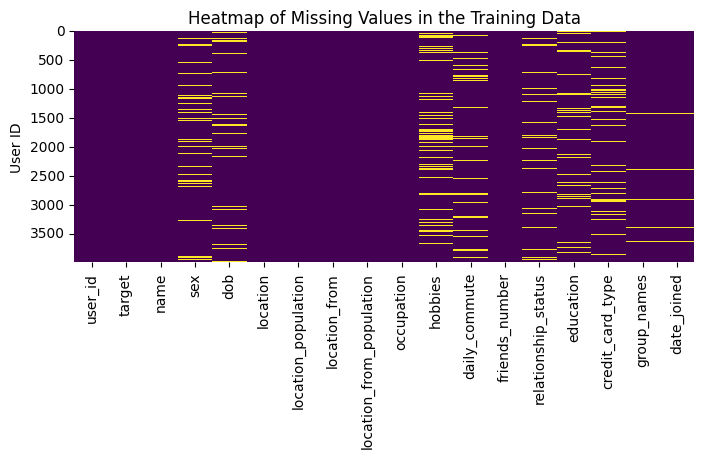

In [8]:
# Create a heatmap to visualize missing values in the training DataFrame
plt.figure(figsize=(8, 3))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')

# Set the title and labels for clarity
plt.title('Heatmap of Missing Values in the Training Data')
plt.yticks(ticks=range(0, len(train_df), 500), labels=range(0, len(train_df), 500))
plt.ylabel('User ID')

# Display the heatmap
plt.show()

At first glance, there appear to be no significant correlations among the missing values, which seem to be randomly and uniformly distributed throughout the sample. I will check whether the missing values correlate with the target feature and each other.

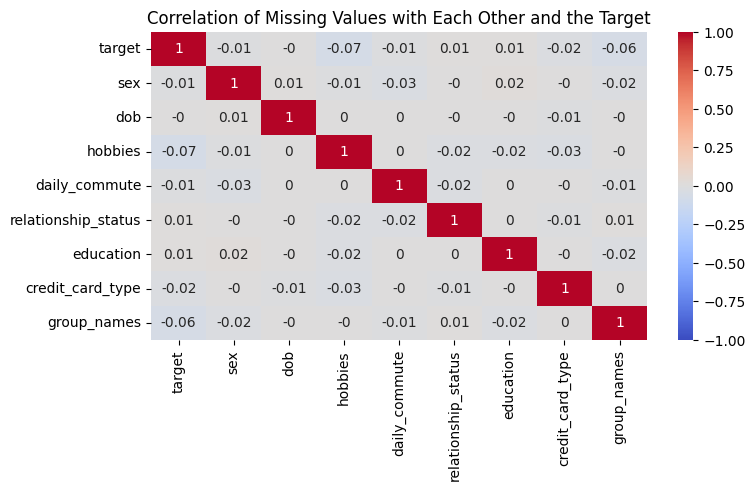

In [9]:
# Create a correlation matrix for missing values

# Create a DataFrame to represent missing values as binary (1 for missing, 0 for not missing)
missing_df = train_df.isnull().astype(int)

# Add the target feature to the missing_df DataFrame for correlation analysis
missing_df['target'] = train_df['target']

# Select specific columns to analyze for correlation with the target feature and other columns
subset_columns = missing_df[['target', 'sex', 'dob', 'hobbies', 'daily_commute', 
                              'relationship_status', 'education', 'credit_card_type', 
                              'group_names']]

# Calculate the correlation matrix for the selected subset of columns
corr_matrix = subset_columns.corr().round(2)

# Set up the figure for the heatmap visualization
plt.figure(figsize=(8, 4))

# Create a heatmap to visualize the correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)

# Title for the heatmap
plt.title('Correlation of Missing Values with Each Other and the Target')

# Show the heatmap
plt.show()

There are no correlations between the missing values, indicating that their absence does not influence the target variable. The missing values appear to be random, with counts ranging from 18 for **date of birth** to 680 for **hobbies** across 4,000 data points. This suggests that a significant number of inputs may not be safely removed from the dataset. 

Moreover, based on domain knowledge, variables with missing values—such as **age**, **hobbies**, and **relationship status**—are likely to significantly impact the target variable. Therefore, further investigation is warranted to assess whether any of these missing values can be omitted.

For now, I have replaced the missing values with `-999` for numerical features and `'missing'` for categorical features to retain information about the absence of data.


In [10]:
# Define markers for missing values
numerical_missing_value_marker = -999  # Example marker for numerical columns
categorical_missing_value_marker = "missing"  # Example marker for categorical columns

# Replace missing values with markers
for df in [train_df, test_df]:
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            df[column].fillna(numerical_missing_value_marker, inplace=True)
        else:
            df[column].fillna(categorical_missing_value_marker, inplace=True)

### Date of Birth variable

Categorical variables, like **date of birth**, must be encoded before training the model. Utilizing full dates results in an unnecessary range of values. For this analysis, **age** is the most pertinent factor, rather than the specific day or month of birth. Consequently, I will convert the date of birth into the client's age, offering a more meaningful representation for the model.


In [11]:
# Calculate the age feature

# Get the current date for calculating ages
current_date = pd.to_datetime(datetime.now())

# Iterate over both the training and test DataFrames
for df in [train_df, test_df]:
    # Convert the 'dob' column to datetime format, coercing errors to NaT (Not a Time)
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce') 
    
    # Calculate the age by subtracting the date of birth from the current date
    # Convert the result from days to years (considering leap years with 365.25 days)
    df['age'] = (current_date - df['dob']).dt.days // 365.25
    
    # Replace any NaN values in the 'age' column with -999 to indicate missing data
    df['age'].fillna(int(-999), inplace=True)

In [12]:
# Remove the Date of Birth column from the training and test DataFrame
train_df.drop('dob', axis=1, inplace=True)
test_df.drop('dob', axis=1, inplace=True)

### Train-validation split

To avoid data leakage in encoding the categorical variables, I perform trainining - validation datasets split now. 

In [98]:
# Split the training dataset into training and validation sets, using 80% of the data for training and 20% for validation, while shuffling the data
train_split, val_split =  train_test_split(train_df, test_size = 0.2, train_size = 0.8, shuffle = True)

### List-structured variables

Some variables—specifically **hobbies**, **group names**, and **date joined**—are lists of categorical data. As they cannot be represented by a single feature (like a median), flattening them isn't ideal since the order of items in the list lacks intrinsic meaning. 

Instead, I will transform each hobby into a new binary column indicating whether a user includes it in their hobby list. This approach will result in **175 new features**, significantly increasing dimensionality while preserving information. For now, I plan to retain only the most impactful features, focusing on the few hobbies with the greatest influence.

Conversely, there are **4,208 unique groups** in the group names column, making it impractical to apply the same method. Instead, I will use **topic modeling** with the **k-means clustering** method to reduce the dimensionality of this feature to **10 group categories**. The model will be trained on the training set and only applied to the test set later to avoid data leakage while ensuring common topics between the two data.kage.


In [318]:
# Transformations functions

def transform_to_list(dataframe, features):
    """
    Convert string representations of lists in specified columns to actual lists.

    Parameters:
    - dataframe: DataFrame containing the data.
    - features: List of columns to transform.

    Returns:
    - DataFrame with transformed columns.
    """
    for feature in features:
        dataframe[feature] = dataframe[feature].apply(
            lambda x: [element.strip() for element in x.split(',')] if isinstance(x, str) else x
        )
    return dataframe

def count_unique_elements(dataframe, features):
    """
    Count unique elements in specified columns.

    Parameters:
    - dataframe: DataFrame containing the data.
    - features: List of columns to count unique elements.

    Returns:
    - List of counts of unique elements for each feature.
    """
    unique_counts = []
    for feature in features:
        unique_values = set()
        for lists in dataframe[feature]:
            unique_values.update(lists)
        num_unique_elements = len(unique_values)
        unique_counts.append(num_unique_elements)
    return unique_counts

def explode_list_features(dataframe, features):
    """
    Explode list features into separate binary columns.

    Parameters:
    - dataframe: DataFrame containing the data.
    - features: List of columns to explode.

    Returns:
    - DataFrame with binary indicator columns for each element in the exploded features.
    """
    for feature in features:
        exploded_df = dataframe.explode(feature)
        elems_dummies = pd.get_dummies(exploded_df[feature])
        elems_binary = elems_dummies.groupby(exploded_df.index).sum()
        dataframe = pd.concat([dataframe, elems_binary], axis=1)
    return dataframe

def check_new_elements(train_df, test_df):
    """
    Check for new hobbies in the test set that are not present in the training set.

    Parameters:
    - train_df: DataFrame containing the training data.
    - test_df: DataFrame containing the test data.

    Returns:
    - Set of new hobbies found in the test set.
    """
    # Transform the hobbies column in both dataframes
    train_df = transform_to_list(train_df, ['hobbies'])
    test_df = transform_to_list(test_df, ['hobbies'])

    # Extract unique hobbies from the training set
    train_hobbies = set(hobby for sublist in train_df['hobbies'] for hobby in sublist)

    # Extract unique hobbies from the test set
    test_hobbies = set(hobby for sublist in test_df['hobbies'] for hobby in sublist)

    # Find new hobbies in the test set
    new_hobbies = test_hobbies - train_hobbies

    return train_hobbies, new_hobbies

# Main function to execute the transformation for features in string (list) format, such as hobbies
def list_transform(dataframe, features):
    """
    Transform and explode list-type features into binary columns.

    Parameters:
    - dataframe: DataFrame containing the data.
    - features: List of features to transform.

    Returns:
    - DataFrame with exploded features and unique element counts.
    """
    df = transform_to_list(dataframe, features)
    unique_counts = count_unique_elements(df, features)
    df_final = explode_list_features(df, features)
    return df_final, unique_counts

def prepare_group_names(train_df, test_df, val_df):
    """
    Explode group names for training, test, and validation data.

    Parameters:
    - train_df: DataFrame containing the training data.
    - test_df: DataFrame containing the test data.
    - val_df: DataFrame containing the validation data.

    Returns:
    - DataFrames with exploded group names.
    """
    exploded_train = train_df.explode('group_names')
    exploded_test = test_df.explode('group_names')
    exploded_val = val_df.explode('group_names')
    return exploded_train, exploded_test, exploded_val

    
def vectorize_group_names(exploded_train, exploded_test, exploded_val):
    """
    Vectorize the exploded group names using CountVectorizer.

    Parameters:
    - exploded_train: DataFrame with exploded training data.
    - exploded_test: DataFrame with exploded test data.
    - exploded_val: DataFrame with exploded validation data.

    Returns:
    - Vectorizer object and matrix representations for training, test, and validation sets.
    """
    vectorizer = CountVectorizer(stop_words='english')
    # Fit on the training data and transform both train and test
    group_name_matrix_train = vectorizer.fit_transform(exploded_train['group_names'])
    group_name_matrix_test = vectorizer.transform(exploded_test['group_names'])
    group_name_matrix_val = vectorizer.transform(exploded_val['group_names'])

    return vectorizer, group_name_matrix_train, group_name_matrix_test, group_name_matrix_val

def train_kmeans(group_name_matrix_train, n_clusters=5):
    """
    Train the KMeans model on the training data.

    Parameters:
    - group_name_matrix_train: Matrix representation of group names for training.
    - n_clusters: Number of clusters for KMeans.

    Returns:
    - Trained KMeans model.
    """
    kmeans_model = KMeans(n_clusters=n_clusters, n_init= 'auto', random_state=42)
    kmeans_model.fit(group_name_matrix_train)
    return kmeans_model

def assign_cluster_topics(exploded_train, exploded_test, exploded_val, vectorizer, kmeans_model):
    """
    Assign cluster labels to each group name using the KMeans model and vectorizer.

    Parameters:
    - exploded_train: DataFrame with exploded training data.
    - exploded_test: DataFrame with exploded test data.
    - exploded_val: DataFrame with exploded validation data.
    - vectorizer: Fitted CountVectorizer.
    - kmeans_model: Trained KMeans model.

    Returns:
    - DataFrames with assigned group topics.
    """
    # Transform group names to vectorized format
    group_name_matrix_train = vectorizer.transform(exploded_train['group_names'])
    group_name_matrix_test = vectorizer.transform(exploded_test['group_names'])
    group_name_matrix_val = vectorizer.transform(exploded_val['group_names'])

    # Assign cluster labels to each group name
    exploded_train['group_topic'] = kmeans_model.predict(group_name_matrix_train)
    exploded_test['group_topic'] = kmeans_model.predict(group_name_matrix_test)
    exploded_val['group_topic'] = kmeans_model.predict(group_name_matrix_val)

    return exploded_train, exploded_test, exploded_val

def aggregate_topics_to_user_level(exploded_df):
    """
    Aggregate the group topics back to the user level by grouping by index.

    Parameters:
    - exploded_df: DataFrame with exploded group topics.

    Returns:
    - Series with group topics aggregated to user level.
    """
    group_topics = exploded_df.groupby(exploded_df.index)['group_topic'].apply(list)
    return group_topics

def replace_group_names_with_topics(train_df, test_df, val_df, train_group_topics, test_group_topics, val_group_topics):
    """
    Replace original group names with their corresponding topic lists.

    Parameters:
    - train_df: DataFrame with training data.
    - test_df: DataFrame with test data.
    - val_df: DataFrame with validation data.
    - train_group_topics: Series with group topics for training.
    - test_group_topics: Series with group topics for test.
    - val_group_topics: Series with group topics for validation.

    Returns:
    - Updated DataFrames with replaced group topics.
    """
    train_df['group_topics'] = train_group_topics
    test_df['group_topics'] = test_group_topics
    val_df['group_topics'] = val_group_topics
    return train_df, test_df, val_df

def process_group_topics(train_transformed, test_full, validation_set, n_clusters=10):
    """
    Process group topics in the given train and test datasets.

    Parameters:
    - train_transformed: DataFrame containing the transformed training data.
    - test_full: DataFrame containing the full test data.
    - validation_set: DataFrame containing the full validation data.
    - n_clusters: Number of clusters for the KMeans model.

    Returns:
    - Updated DataFrames with replaced group names by topics.
    """
    exploded_train, exploded_test, exploded_val = prepare_group_names(train_transformed, test_full, validation_set)

    vectorizer, group_name_matrix_train, group_name_matrix_test, group_name_matrix_val = vectorize_group_names(exploded_train, exploded_test, exploded_val)

    kmeans_model = train_kmeans(group_name_matrix_train, n_clusters=n_clusters)

    exploded_train, exploded_test, exploded_val = assign_cluster_topics(exploded_train, exploded_test, exploded_val, vectorizer, kmeans_model)

    train_group_topics = aggregate_topics_to_user_level(exploded_train)
    test_group_topics = aggregate_topics_to_user_level(exploded_test)
    val_group_topics = aggregate_topics_to_user_level(exploded_val)

    train_transformed, test_transformed, val_transformed = replace_group_names_with_topics(train_transformed, test_full, validation_set, train_group_topics, test_group_topics, val_group_topics)

    return train_transformed, test_transformed, val_transformed, exploded_train

def show_common_words(exploded_df, num_words=5):
    """
    Display the most common words used in each cluster, excluding stop words.

    Parameters:
    - exploded_df: DataFrame with exploded group names and topics.
    - num_words: Number of common words to display for each cluster.

    Returns:
    - Dictionary of most common words for each cluster.
    """
    count_vectorizer = CountVectorizer(stop_words='english')
    
    group_name_matrix = count_vectorizer.fit_transform(exploded_df['group_names'])
    feature_names = count_vectorizer.get_feature_names_out()
    
    cluster_word_counts = pd.DataFrame(data=group_name_matrix.toarray(), columns=feature_names)
    cluster_word_counts['group_topic'] = exploded_df['group_topic'].values
    common_words = cluster_word_counts.groupby('group_topic').sum()
    most_common_words_list = []

    
    for cluster in common_words.index:
        sorted_words = common_words.loc[cluster].sort_values(ascending=False).head(num_words)
        most_common_words_list.append({'Group Topic': cluster, 'Common Words': sorted_words.index.tolist()})

    # Create DataFrame from the list of dictionaries
    most_common_words_df = pd.DataFrame(most_common_words_list)

    return most_common_words_df



In [319]:
# Process hobbies and hobbies groups topics

train_trans, test_trans, val_trans, exploded_train = process_group_topics(train_split, test_df, val_split, n_clusters=10)

# Transform the 'hobbies' feature in the training dataset
train_trans, unique_hobby_count = list_transform(train_trans, ['hobbies'])

# Check for new hobbies in the test dataset that are not present in the training dataset
train_hobbies, new_hobbies_in_test = check_new_elements(train_trans, test_trans)
if new_hobbies_in_test:  # Only print if there are new hobbies
    print('There are ' + str(len(new_hobbies_in_test)) + ' new hobbies found in the test dataset that were not seen in the training.')

# Check for new hobbies in the validation dataset that are not present in the training dataset
train_hobbies, new_hobbies_in_val = check_new_elements(train_trans, val_split)
if new_hobbies_in_val:  # Only print if there are new hobbies
    print('There are ' + str(len(new_hobbies_in_val)) + ' new hobbies found in the validation dataset that were not seen in the training.')

# Transform the 'hobbies' feature in the test dataset, converting it to a binary format
test_trans, unique_hobby_count_test = list_transform(test_trans, ['hobbies'])

# Transform the 'hobbies' feature in the validation dataset, converting it to a binary format
val_trans, unique_hobby_count_val = list_transform(val_trans, ['hobbies'])

# Display the most common words used in each cluster from the exploded training data, showing the top 5 words per cluster
common_words_per_cluster = show_common_words(exploded_train, num_words=5)

In [336]:
# Output the common words found in each cluster
display(Markdown("### The clusters found in topic modelling are:"))
common_words_per_cluster

### The clusters found in topic modelling are:

,Group Topic,Common Words
0,0,"[hypnosis, medicine, alternative, bioenergothe..."
1,1,"[looking, rent, join, fans, online]"
2,2,"[data, world, big, statistics, mining]"
3,3,"[school, technical, electronics, automotive, w..."
4,4,"[big, puppy, pet, people, want]"
5,5,"[healthy, lifestyle, food, mind, body]"
6,6,"[group, join, dancing, calse, singles]"
7,7,"[gym, fitness, climbing, bike, excercise]"
8,8,"[work, abroad, join, enjoy, paid]"
9,9,"[cars, used, group, sale, warszawa]"


The output reveals the most common words associated with each cluster, highlighting users' interests and activities:

- **Cluster 0** focuses on *alternative medicine* and *hypnosis*, indicating an interest in holistic health practices.
- **Cluster 1** emphasizes *online engagement*, with terms like *looking*, *join*, and *fans*, suggesting a community-driven approach.
- **Cluster 6** brings together interests in *social dancing* and *group activities*, particularly for *singles*.
- **Cluster 7** is geared towards *fitness and outdoor activities*, featuring words like *gym*, *climbing*, and *exercise*.
- **Cluster 9** focuses on *automotive sales*, with terms like *cars* and *used*.

There are recurring location names, such as *Warszawa*, *Łódź*, *Kraków*, and *Poznań*. The presence of these location names may skew the insights. To enhance the analysis, it would be beneficial to remove these location names before interpreting the results. This will allow for a clearer understanding of users' hobbies and preferences, especially since location information is already included in the dataset.
ataset.



In [277]:
# Transform the 'group_topics' feature for training, test, and validation datasets
train_trans, nums_unique_train = list_transform(train_trans, ['group_topics'])
test_trans, nums_unique_test = list_transform(test_trans, ['group_topics'])
val_trans, nums_unique_val = list_transform(val_trans, ['group_topics'])

# Drop unnecessary columns from all datasets to clean up the DataFrames
for df in [train_trans, test_trans, val_trans]:
    df.drop(['group_names', 'group_topics', 'hobbies', 'date_joined'], axis=1, inplace=True)


### Exploratory Data Analysis

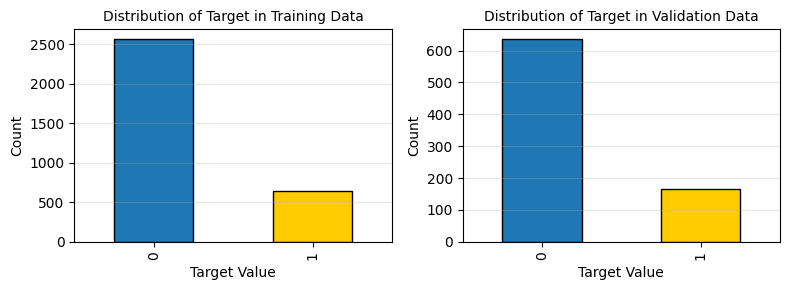

In [251]:
# Plot distribution of target value
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

colors = ['#1f77b4', '#ffcc00'] 

# Histogram for training data
train_counts = train_trans['target'].value_counts()
train_counts.plot(kind='bar', ax=ax[0], color=colors, edgecolor='black')
ax[0].set_title('Distribution of Target in Training Data', fontsize=10)
ax[0].set_xlabel('Target Value', fontsize=10)
ax[0].set_ylabel('Count', fontsize=10)
ax[0].set_xticks([0, 1])  
ax[0].set_xticklabels(['0', '1']) 
ax[0].grid(axis='y', alpha=0.3) 

# Histogram for validation data
val_counts = val_trans['target'].value_counts()
val_counts.plot(kind='bar', ax=ax[1], color=colors, edgecolor='black')
ax[1].set_title('Distribution of Target in Validation Data', fontsize=10)
ax[1].set_xlabel('Target Value', fontsize=10)
ax[1].set_ylabel('Count', fontsize=10)
ax[1].set_xticks([0, 1]) 
ax[1].set_xticklabels(['0', '1'])  
ax[1].grid(axis='y', alpha=0.3)  

# Show the plots
plt.show()

The distribution of the target variables is comparable between the test and validation datasets, confirming that the random sampling for the split was effective. However, the ratio of the target values (1 and 0), which indicate initial interest in a long-term gym subscription, is uneven:

- **Instances of '1':** Approximately five times more than instances of '0'.

This mild imbalance may introduce some bias into the model, but it is not expected to be significant. Additionally, we are not working with highly sensitive cases where the undersampled output is critical, such as:

- Anomaly detection in financial transactions.
- Identification of life-threatening diseases.

Nevertheless, if necessary, it could be beneficial to apply sampling techniques like **SMOTE** or **random undersampling** to address the imbalance.
balance.




Next, I analyse the distribution of the target variable across various features in the dataset. This examination reveals the relationships between the target and individual features. By plotting each feature's distribution for both target categories, I can identify differences between the groups, highlighting patterns and potential feature importance. This analysis provides early insights into which attributes may be more predictive of the target variable.

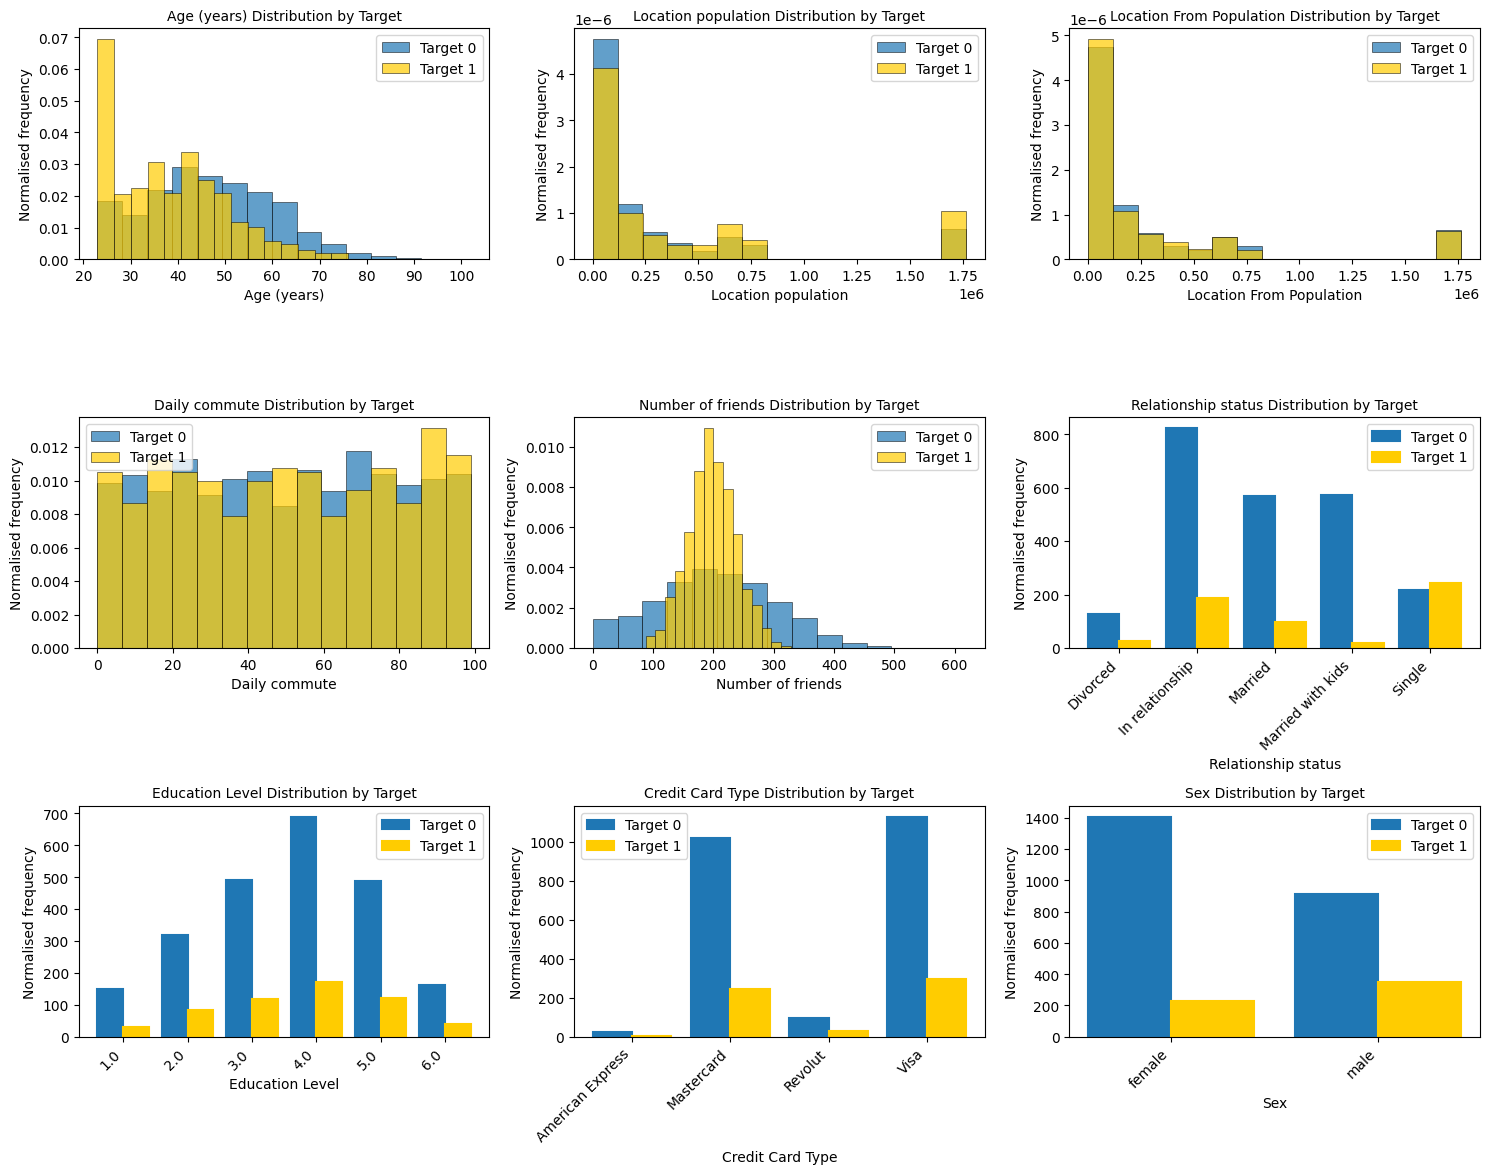

In [252]:
def plot_distribution(ax, dataframe, feature, name_of_feature, colors, feature_type):
    # Check the data type of the feature and filter accordingly
    if dataframe[feature].dtype in ['float64', 'int64']:
        filtered_train_df = dataframe[dataframe[feature] != -999]
    elif dataframe[feature].dtype == 'object':
        filtered_train_df = dataframe[dataframe[feature] != 'missing']
    else:
        print(f'Unknown data type for {feature}')
        return  # Exit the function if the type is unknown
    
    if feature_type == 'categorical':
        # For categorical data, apply an offset to separate the bars
        width = 0.4  # Set bar width
        categories = sorted(filtered_train_df[feature].unique())  # Get unique categories and sort them
        
        # Count occurrences for target 0
        counts_0 = filtered_train_df[filtered_train_df['target'] == 0][feature].value_counts().reindex(categories, fill_value=0)
        
        # Count occurrences for target 1
        counts_1 = filtered_train_df[filtered_train_df['target'] == 1][feature].value_counts().reindex(categories, fill_value=0)

        # Plot bars for target 0 with an offset
        ax.bar(np.arange(len(categories)) - width/2, counts_0, width=width, alpha=1, color=colors[0], label='Target 0', edgecolor=colors[0], linewidth=1.5)

        # Plot bars for target 1 with an offset
        ax.bar(np.arange(len(categories)) + width/2, counts_1, width=width, alpha=1, color=colors[1], label='Target 1', edgecolor=colors[1], linewidth=1.5)
        
        # Set x-axis labels for categorical features
        ax.set_xticks(np.arange(len(categories)))
        ax.set_xticklabels(categories, rotation=45, ha='right')

    else:
        # For numerical data, plot histograms normally (superimposed)
        ax.hist(filtered_train_df[filtered_train_df['target'] == 0][feature], 
                bins=15, alpha=0.7, color=colors[0], label='Target 0', density=True, edgecolor='black', linewidth=0.5)

        ax.hist(filtered_train_df[filtered_train_df['target'] == 1][feature], 
                bins=15, alpha=0.7, color=colors[1], label='Target 1', density=True, edgecolor='black', linewidth=0.5)

     # Adding labels and title
    ax.set_xlabel(name_of_feature, fontsize=10)
    ax.set_ylabel('Normalised frequency', fontsize=10)
    ax.set_title(str(name_of_feature) + ' Distribution by Target', fontsize=10)
    ax.legend()



# Create a grid of subplots with a defined figure size
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # 3 rows, 3 columns grid

# Define colors for the two target categories
colors_test = [colors[0], colors[1]]

# Flatten the 2D array of axes to easily iterate over
axs = axs.ravel()

# List of features and names to plot
features = ['age', 'location_population', 'location_from_population', 'daily_commute', 'friends_number', 
            'relationship_status', 'education', 'credit_card_type', 'sex']
names = ['Age (years)', 'Location population', 'Location From Population', 'Daily commute', 'Number of friends',
         'Relationship status', 'Education Level', 'Credit Card Type', 'Sex']
types = ['numerical', 'numerical', 'numerical', 'numerical', 'numerical', 'categorical', 'categorical','categorical','categorical',  ]

# Plot each feature in a different subplot
for i, feature in enumerate(features):
    plot_distribution(axs[i], train_trans, feature, names[i], colors, types[i])

# Adjust layout
plt.tight_layout()

# Show the full grid of plots
plt.show()


From the histograms, it is evident that there are distinct differences in the distributions of target values based on several factors:

- **Sex**: Women are less likely to show interest in long-term gym subscriptions compared to men.
- **Relationship Status**: 
  - Single individuals have a significantly higher probability of being interested, with an approximate 50:50 ratio compared to other groups.
  - People in relationships show a higher probability of interest than married individuals.
  - Married individuals with children are the least likely to express interest.
- **Age Groups**: There is a slight difference in distributions across different age groups.
  
Conversely, features such as daily commute distance, location po friends, and credit card type appear to follow similar distribution patterns.

This analysis will be further investigated using statistical tools, complementing the insights gained from visualization.


To visualize the **distributions of locations**, I use the GeoPandas library to create heatmaps on a map of Poland. Three heatmaps are presented: one for target value 0, one for target value 1, and one for the normalized target value 1. This allows for a clear representation of each target's distribution, with the two target values superimposed, as well as highlighting areas with a higher ratio of individuals interested in subscriptions.


In [48]:
# Load the dataset from the downloaded shapefile path
poland = gpd.read_file('C:/Users/defra/Downloads/110m_cultural/ne_110m_admin_0_countries.shp')
poland = poland[poland.NAME == 'Poland']

city_counts = train_trans.groupby(['location', 'target']).size().unstack(fill_value=0)
city_counts = city_counts.reset_index()

# Get unique city names from the 'location' column
unique_city_names = city_counts['location'].tolist()

# Initialize geocoder
geolocator = Nominatim(user_agent="city_coordinates")

# Create a DataFrame to hold the city names and their coordinates
coords = []

# Get coordinates for each unique city
for city in unique_city_names:
    location = geolocator.geocode(city + ", Poland")
    if location:
        coords.append((city, location.latitude, location.longitude))

# Create a DataFrame from the coordinates
coords_df = pd.DataFrame(coords, columns=['city', 'latitude', 'longitude'])

# Merge city coordinates with city counts
merged_df = pd.merge(coords_df, city_counts, left_on='city', right_on='location', how='left')

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(merged_df[['latitude', 'longitude']])

In [49]:
from IPython.display import IFrame


# Create a Folium map centered on Poland, with bounds locked to Poland's geographic area
m = folium.Map(
    location=[52.0675, 19.1451], 
    zoom_start=6,
)

# Add the polygon of Poland to the map
folium.GeoJson(poland, style_function=lambda x: {'fillColor': '#FFFFFF', 'color': '#000000', 'weight': 2}).add_to(m)

# Prepare data for heatmap for target variable 0
heat_data_target_0 = []
for index, row in merged_df.iterrows():
    for _ in range(row[0]):  # Repeat the coordinates based on the count for target 0
        heat_data_target_0.append([row['latitude'], row['longitude']])

# Prepare data for heatmap for target variable 1
heat_data_target_1 = []
for index, row in merged_df.iterrows():
    for _ in range(row[1]):  # Repeat the coordinates based on the count for target 1
        heat_data_target_1.append([row['latitude'], row['longitude']])

# Prepare data for heatmap for the normalsed target variable 1
heat_data_normalized = []
for index, row in merged_df.iterrows():
    total_count = row[0] + row[1]  # Total count for both target values
    if total_count > 0:  # Avoid division by zero
        proportion = row[1] / total_count  # Normalizing based on total counts for that location
        heat_data_normalized.append([row['latitude'], row['longitude'], proportion])  # Append latitude, longitude, and proportion


# Add heatmaps to the map
HeatMap(heat_data_target_0, radius=10, blur=10, name='Target 0 Heatmap', 
        gradient={0.0: 'lightblue', 0.5: 'cyan', 1.0: 'blue'}).add_to(m)
HeatMap(heat_data_target_1, radius=10, blur=10, name='Target 1 Heatmap', 
        gradient={0.0: 'yellow', 0.5: 'orange', 1.0: 'red'}).add_to(m)

# Create the heatmap for target variable 1 normalized to total counts
HeatMap(heat_data_normalized, radius=10, blur=10, name='Normalized Target 1 Heatmap',
        gradient={0.0: 'white', 0.5: 'pink',1.0: 'purple'}).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)


# Save the map to an HTML file
m.save("poland_city_heatmap.html")
# Display map in a custom-sized IFrame
IFrame('poland_city_heatmap.html', width=650, height=400)

The results meet expectations, indicating that the highest concentrations of data points are found in major cities such as Warsaw, Katowice, Trójmiasto, and Łódź for both target values. These regions also exhibit high ratios of individuals interested in gym subscriptions.

Interestingly, there are other cities with notable ratios, including Wałbrzych, Prochowice, and some scattered locations in Województwo Wielkopolskie.


Lastly, I am taking a closer look at the **hobbies and hobby groups**. 

In [278]:
# Prepare data for hobbies exploration
filtered_train = train_trans.loc[:, train_trans.columns.isin(train_hobbies) | (train_trans.columns == 'target')]
target0 = filtered_train[filtered_train['target']==0].sum()
target1 = filtered_train[filtered_train['target']==1].sum()
target0 = target0.drop(index=['missing', 'target'], errors='ignore')
target1 = target1.drop(index=['missing', 'target'], errors='ignore')

# Calculate the total counts for both target values
total_counts_target0 = target0.sum()
total_counts_target1 = target1.sum()

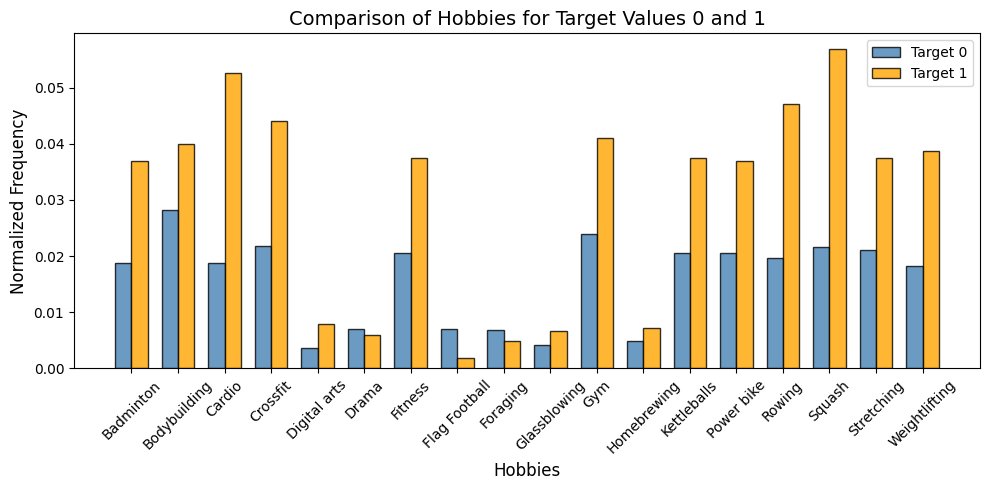

In [279]:
# Get the top 15 hobbies for both target values
top_10_target0 = target0.nlargest(15).index
top_10_target1 = target1.nlargest(15).index

# Calculate the total counts for both target values
total_counts_target0 = target0.sum()
total_counts_target1 = target1.sum()

# Combine and get unique popular hobbies from both target values
popular_hobbies = list(set(top_10_target0).union(set(top_10_target1)))

# Filter target0 and target1 to include only the popular hobbies and normalize their counts
filtered_target0 = target0[target0.index.isin(popular_hobbies)] / total_counts_target0
filtered_target1 = target1[target1.index.isin(popular_hobbies)] / total_counts_target1

# Prepare data for plotting
labels = filtered_target0.index  # Hobbies as labels for the x-axis
values_target0 = filtered_target0.values  # Normalized values for target 0
values_target1 = filtered_target1.values  # Normalized values for target 1

# Set up the bar positions for the histogram
x = range(len(labels))  # Position for each bar
width = 0.35  # Width of the bars

# Create a figure and axis for the plot with increased width
plt.figure(figsize=(10, 5))  # Set the size of the figure (width, height)

# Create the bar for target value 0
plt.bar(x, values_target0, width=width, label='Target 0', alpha=0.8, color='steelblue', edgecolor='black')

# Create the bar for target value 1, offsetting its position by the width of the bars
plt.bar([p + width for p in x], values_target1, width=width, label='Target 1', alpha=0.8, color='orange', edgecolor='black')

# Adding labels and title
plt.xlabel('Hobbies', fontsize=12)  # X-axis label
plt.ylabel('Normalized Frequency', fontsize=12)  # Y-axis label
plt.title('Comparison of Hobbies for Target Values 0 and 1', fontsize=14)  # Title of the plot
plt.xticks([p + width / 2 for p in x], labels, rotation=45)  # X-tick labels positioned correctly
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout to make room for x-axis labels

# Show the plot
plt.show()


The histogram above displays the most common hobbies associated with both target variables, with values normalised for comparison. 

- **Yellow Bars:** Represent individuals interested in long-term gym subscriptions. This aligns with the logical assumption that those with a preference for sport-related hobbies are more likely to belong to this group.

- **Balanced Ratios:** Hobbies such as and glassblowing drama show more balanced ratios between the two target groups.

- **Less Likely Hobbies:** Individuals inter flag football and foraging oration tend to be less likely to pursue a gym subsc

Another interesting visualisation would be to consider hobbies for which there is a **biggest imbalance** between the target values.iption.


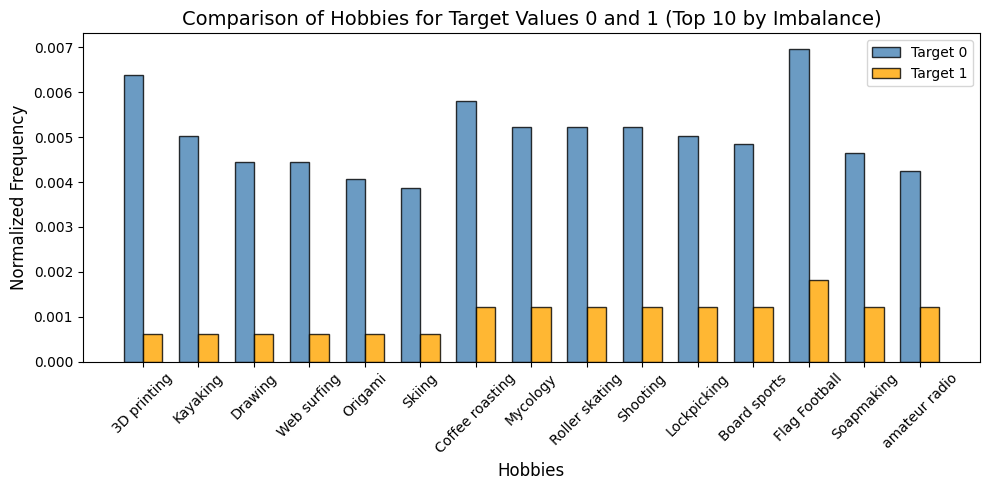

In [280]:
# Filter target0 and target1 to include all hobbies and normalize their counts
filtered_target0 = target0 / total_counts_target0
filtered_target1 = target1 / total_counts_target1

# Create a DataFrame to hold both target values for easier manipulation
ratios_df = pd.DataFrame({
    'target0': filtered_target0,
    'target1': filtered_target1
})

# Calculate the ratio of larger to smaller normalized counts
ratios_df['ratio'] = ratios_df[['target0', 'target1']].max(axis=1) / ratios_df[['target0', 'target1']].min(axis=1)

# Get the top 10 hobbies with the highest ratio of imbalance
top_hobbies = ratios_df.nlargest(15, 'ratio')

# Prepare data for plotting
labels = top_hobbies.index  # Hobbies as labels for the x-axis
values_target0 = top_hobbies['target0'].values  # Normalized values for target 0
values_target1 = top_hobbies['target1'].values  # Normalized values for target 1

# Set up the bar positions for the histogram
x = range(len(labels))  # Position for each bar
width = 0.35  # Width of the bars

# Create a figure and axis for the plot with increased width
plt.figure(figsize=(10, 5))  # Set the size of the figure (width, height)

# Create the bar for target value 0
plt.bar(x, values_target0, width=width, label='Target 0', alpha=0.8, color='steelblue', edgecolor='black')

# Create the bar for target value 1, offsetting its position by the width of the bars
plt.bar([p + width for p in x], values_target1, width=width, label='Target 1', alpha=0.8, color='orange', edgecolor='black')

# Adding labels and title
plt.xlabel('Hobbies', fontsize=12)  # X-axis label
plt.ylabel('Normalized Frequency', fontsize=12)  # Y-axis label
plt.title('Comparison of Hobbies for Target Values 0 and 1 (Top 10 by Imbalance)', fontsize=14)  # Title of the plot
plt.xticks([p + width / 2 for p in x], labels, rotation=45)  # X-tick labels positioned correctly
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout to make room for x-axis labels

# Show the plot
plt.show()



Interestingly, the hobbies with the most significant imbalance are not primarily gym-related. Some of these hobbies are associated with sports, such as **roller skating, d **skiing and **kayaking****. However, these activities are outdoor sports that do not necessarily require gym amenities.

While these hobbies could potentially indicate a user's propensity to subscribe to a gym, they are also less common, exhibiting lower overall frequencies in the dataset. Therefore, they may not be as significant as initially assumed. This topic will be further investigated in the featselectionring section.


### Categorical variables

Having investigated the variables in detail, the next step is to encode the categorical variables into numerical values. This encoding is necessary for applying machine learning models, as they require numerical input. Techniques like **label encoding** will be used, ensuring that the models can effectively interpret the data and improve predictive performance.

In [256]:
# Identify categorical columns in the training dataset
categorical_cols = train_trans.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize LabelEncoders and encoding mappings
label_encoders = {}
encoding_mappings = {}

for col in categorical_cols:
    le = LabelEncoder()

    # Check for lists in training data and convert to strings
    if train_trans[col].apply(lambda x: isinstance(x, list)).any():
        train_trans[col] = train_trans[col].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)

    # Fit and transform the training data
    train_trans[col] = le.fit_transform(train_trans[col].astype(str))
    label_encoders[col] = le
    encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Convert mapping values to standard int
encoding_mappings = {
    col: {k: int(v) for k, v in mapping.items()}
    for col, mapping in encoding_mappings.items()
}

# Save the encoding mappings to JSON
with open('encoding_mappings.json', 'w') as f:
    json.dump(encoding_mappings, f)

# Ensure the same categorical columns are present in the validation and test data
val_categorical_cols = val_trans.select_dtypes(include=['object', 'category']).columns.tolist()
test_categorical_cols = test_trans.select_dtypes(include=['object', 'category']).columns.tolist()

# Check for new categorical columns in validation dataset
new_val_categorical_cols = set(val_categorical_cols) - set(categorical_cols)
if new_val_categorical_cols:
    print(f"New Categorical Columns in Validation: {new_val_categorical_cols}")

# Check for new categorical columns in test dataset
new_test_categorical_cols = set(test_categorical_cols) - set(categorical_cols)
if new_test_categorical_cols:
    print(f"New Categorical Columns in Test: {new_test_categorical_cols}")

# Apply the same LabelEncoders to the validation and test data
for col in categorical_cols:
    if col in label_encoders:  # Check if the column was in the training data
        # Convert list columns in test data to strings as done in training data
        if test_trans[col].apply(lambda x: isinstance(x, list)).any():
            test_trans[col] = test_trans[col].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)

        # Transform the test data, with handling for unseen labels
        test_trans[col] = test_trans[col].apply(
            lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
        )

# Repeat the same for the validation dataset
for col in categorical_cols:
    if col in label_encoders:  # Check if the column was in the training data
        # Convert list columns in validation data to strings as done in training data
        if val_trans[col].apply(lambda x: isinstance(x, list)).any():
            val_trans[col] = val_trans[col].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)

        # Transform the validation data, with handling for unseen labels
        val_trans[col] = val_trans[col].apply(
            lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
        )

In [257]:
display(Markdown("#### Transformed datasets look like that:"))
train_trans.head()

#### Transformed datasets look like that:

,user_id,target,name,sex,location,location_population,location_from,location_from_population,occupation,daily_commute,...,0,1,2,3,4,5,6,7,8,9
2386,2386,0,69,1,119,95629,8,23810,13,44.00,...,0,1,0,0,0,0,0,0,0,1
2442,2442,0,196,0,486,1764615,496,1764615,27,78.00,...,0,2,0,0,0,0,1,0,0,0
3873,3873,0,128,0,445,403883,187,46568,23,66.00,...,0,3,0,0,0,0,0,0,0,0
3754,3754,0,140,1,445,403883,361,30468,22,60.00,...,0,3,0,0,0,0,0,0,0,0
1591,1591,0,120,0,154,101625,154,101625,30,86.00,...,0,2,0,0,0,0,2,0,0,0


In [258]:
# Convert all column names to strings
train_trans.columns = train_trans.columns.astype(str)
val_trans.columns = val_trans.columns.astype(str)
test_trans.columns = test_trans.columns.astype(str)


The range of numbers for the features are above is very large. To avoid bias in the model caused by large numbers for some of the variables, such as location population, I use Standard Scaler, making sure it doesn't affect target value or user ID that is not needed in the further analysis. 

In [259]:
# Scale the numerical values 

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Split the data into features and target variable
X_train = train_trans.drop(columns=['target', 'user_id'])  # Features
y_train = train_trans['target']  # Target variable

X_val = val_trans.drop(columns=['target', 'user_id'])  # Features
y_val = val_trans['target']  # Target variable

X_test = test_trans.drop(columns=['target', 'user_id'])  # Features
y_test = test_trans['target']  # Target variable
id_test = test_trans['user_id']

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)


# Transform the validation and test data using the fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create DataFrames from the scaled arrays while preserving the column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Combine the scaled features with the target variable to create train_trans
train_trans = X_train.copy()  # Use a copy to avoid SettingWithCopyWarning
train_trans['target'] = y_train.reset_index(drop=True)  # Reset index to align with X_train

val_trans = X_val.copy()  # Use a copy to avoid SettingWithCopyWarning
val_trans['target'] = y_val.reset_index(drop=True)  # Reset index to align with X_train

test_trans = X_test.copy()  # Use a copy to avoid SettingWithCopyWarning
test_trans['target'] = y_test.reset_index(drop=True)  # Reset index to align with X_train


# Model Selection and Training

## Feature Selection

The current dataset comprises 195 variables, which can lead to inefficiencies in model training. Therefore, it is essential to select the most significant variables. I employed two methods for this:

1. **Correlation Matrix**: This method captures the linear relationships between the features and the target variable.  
2. **Random Forest Feature Importance**: This approach measures the contribution of each feature to the model's predictions and can identify complex, non-linear relationships and interactions between features that the correlation matrix may overlook.

I plotted the most significant features identified by both methods below. For the correlation matrix, the significant features are chosen as those that have correlation values larger than 0.1 or smaller than -0.1, while for Random Forest I am choosing 25 most important features after having plotted them all and finding where the importances plateau. Some features appeared in both analyses:

**Common Features**:
- Sex
- Relationship status
- Hobbies from groups/clusters 1, 6 and 7
- Hobbies: cardio, squash, rowing, crossfit, weightlifting, badminton

This aligns with the visual distributions examined earlier.

**Unique Features**:
- **Included by Random Forest**: Number of friends, age, location details (including population), occupation, education, credit card type
  
When deciding which features to retain, I will focus on those identified by both methods, as they provide a solid basis for inclusion. Additionally, I will consider the features identified by the Random Forest analysis, as it effectively measures non-linear correlations.
ear correlations.
near correlations.
linear correlations.


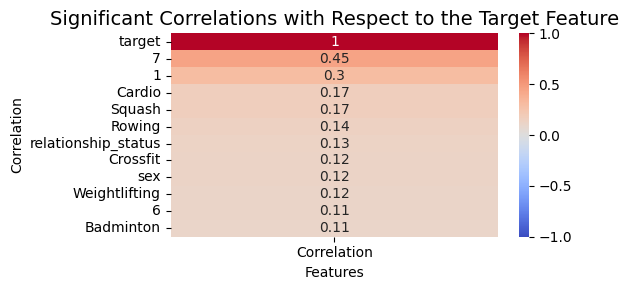

In [260]:
# Calculate the correlation matrix
correlation_matrix = train_trans.corr()

# Get the correlation with respect to the target
target_correlation = correlation_matrix['target']
corr = target_correlation.to_frame()
corr.columns = ['Correlation']

# Filter out features with correlation values between -0.1 and 0.1
filtered_corr = corr[(corr['Correlation'] < -0.1) | (corr['Correlation'] > 0.1)].copy()

# Sort the filtered correlations by their absolute values in descending order
filtered_corr['Absolute_Correlation'] = filtered_corr['Correlation'].abs()
filtered_corr = filtered_corr.sort_values(by='Absolute_Correlation', ascending=False)

# Drop the temporary Absolute_Correlation column
filtered_corr = filtered_corr.drop(columns=['Absolute_Correlation'])

# Plotting
palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(6, 3)) 
sns.heatmap(filtered_corr, annot=True, cmap=palette, cbar=True, vmin=-1, vmax=1)
plt.title('Significant Correlations with Respect to the Target Feature', fontsize=14)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Correlation', fontsize=10)

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

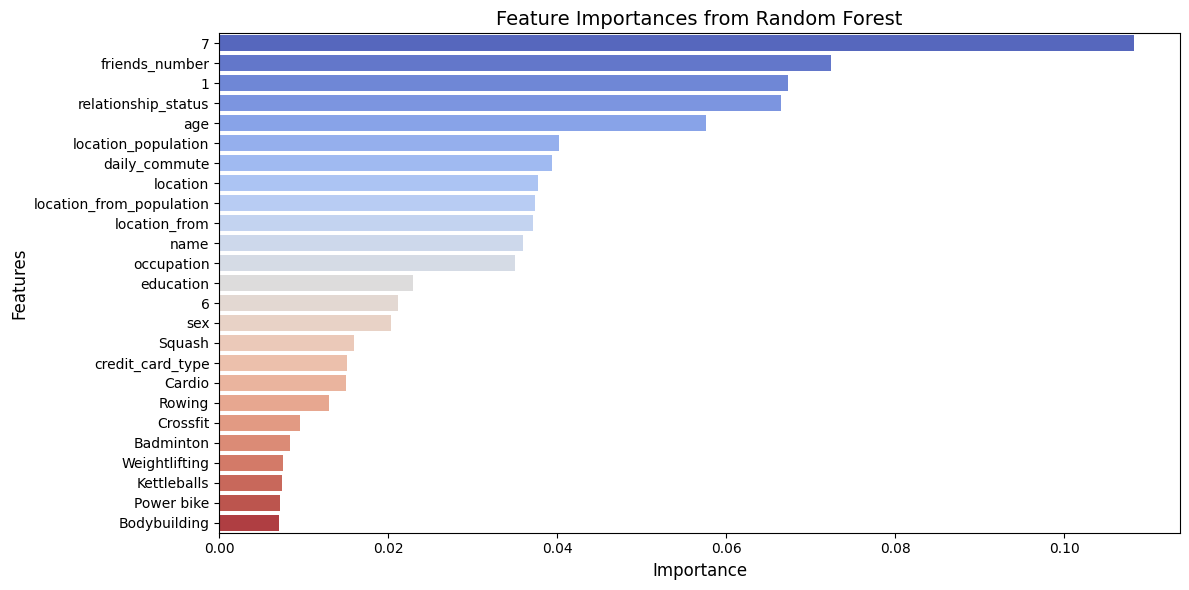

In [261]:
# Prepare the features and target variable
X = train_trans.drop(columns=['target'])  # Features
y = train_trans['target']  # Target variable

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Filter out features with importance close to zero
importance_df = importance_df[importance_df['Importance'] > 0]

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

palette = sns.color_palette("coolwarm", n_colors=min(len(importance_df), 25))

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.iloc[:25], palette=palette, hue='Feature', legend=False)
plt.title('Feature Importances from Random Forest', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()

I selected the most significant features using the Random Forest model, intentionally omitting the location, original location, and name values due to their variability. While certain locations, such as Warsaw, may offer insights—like indicating a higher interest in gyms due to a large population and many young people—the names themselves lack the nuance required for effective analysis. Additionally, the population feature already distinguishes between large and small cities, making the location names redundant.

In [262]:
# Selecting 30 most important features recognised by Random Forest
selected_features = importance_df['Feature'].head(30).tolist() + ['target']
selected_features = [feature for feature in selected_features if feature not in [ 'location', 'location_from', 'name']]

In [263]:
# Transform the datasets for model training
train_final, val_final, test_final = train_trans[selected_features], val_trans[selected_features], test_trans[selected_features]

X_train = train_final.drop(columns=['target'])  # Features
y_train = train_final['target']  # Target variable

X_val = val_final.drop(columns=['target'])  # Features
y_val = val_final['target']  # Target variable

X_test = test_final.drop(columns=['target'])  # Features
y_test = test_final['target']  # Target variable

## Model Training

With the data prepared, we can now train the models. In this analysis, I compare three different models commonly used in classification problems, starting with the simplest — **Logistic Regression**, and then moving to more sophisticated algorithms like **LightGBM** and **XGBoost**.

### 1. Logistic Regression  
Logistic Regression is a straightforward linear classifier. It has the advantage of fast training times and is easy to interpret. However, it only captures **linear relationships** between features and the target, which may not be sufficient for this problem. As we have seen from the data exploration, the relationships could be more complex.

Additionally, Logistic Regression requires well-processed data — it benefits from **scaling the features** to ensure that no single feature biases the model due to its magnitude. Despite its simplicity, it can underperform when the data contains non-linear patterns or interactions between features.

### 2. LightGBM  
LightGBM (Light Gradient Boosting Machine) is a **gradient boosting algorithm** that builds decision trees to capture **non-linear relationships** between the features and target. It is known for being fast and memory efficient, making it ideal for large datasets.

One of the key advantages of LightGBM is that it can handle **missing data** and is optimized to capture both linear and non-linear relationships efficiently. Its **leaf-wise splitting** and histogram-based approach contribute to faster model training while maintaining high performance on complex datasets.

### 3. XGBoost  
XGBoost (Extreme Gradient Boosting) is another gradient boosting algorithm known for its **flexibility and fine-tuned hyperparameters**. While XGBoost can potentially provide better results than LightGBM due to its exhaustive parameter tuning options, it typically requires **longer training times**. 

XGBoost has many configurable hyperparameters that allow for **greater control** over the model’s behavior, such as tree depth, learning rate, and regularization parameters. However, this comes at the cost of complexity, making it harder to optimize comparhen carefully tuned.

In this classification task, **LightGBM** and **XGBoost** are expected to outperform Logistic Regression due to the presence of **non-linear relationships** in the data.

The **confidence threshold** for the models has been chosen after plotting the distribution of probabilities of the target variable to optimise the recall on the target 1.


### Logistic Regression

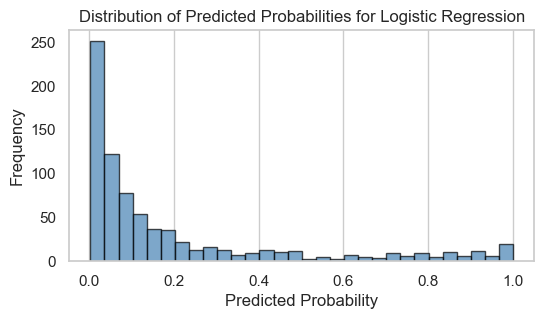

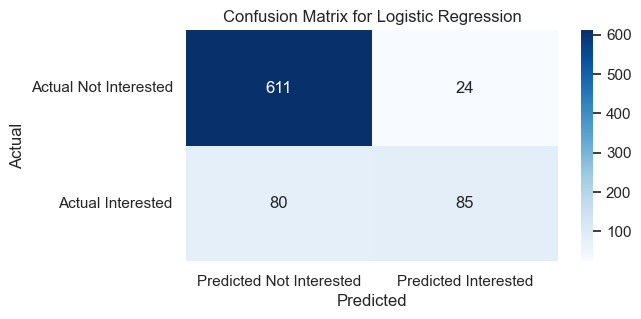

In [399]:
# Logistic Regression model training

logistic_model = LogisticRegression(random_state=42, max_iter=100)
logistic_model.fit(X_train, y_train)

# Get predicted probabilities for the validation set
probabilities = logistic_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

# Create a histogram to visualise the predicted probabilities
plt.figure(figsize=(6, 3))
plt.hist(probabilities, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for Logistic Regression')
plt.grid(axis='y')
plt.show()

# Define a confidence threshold
confidence_threshold = 0.5

# Make predictions based on the defined threshold
y_val_pred = (probabilities >= confidence_threshold).astype(int)

conf_matrix_logreg = confusion_matrix(y_val, y_val_pred)
class_report_logreg = classification_report(y_val, y_val_pred)

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Interested', 'Predicted Interested'], yticklabels=['Actual Not Interested', 'Actual Interested'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

### LightGBM

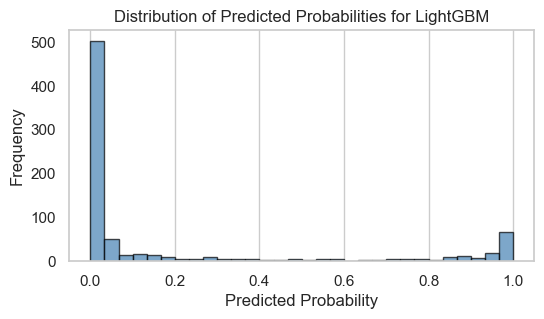

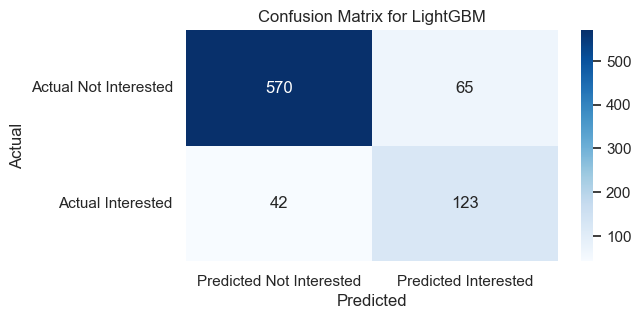

In [392]:
# LightGBM model training

#I am using balanced class weight to give more importance to the minority class during training. 
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=200, num_leaves = 35, class_weight='balanced', verbose = -1)

# Fit the model on the training data
lgb_model.fit(X_train, y_train)

# Get predicted probabilities for the validation set
probabilities = lgb_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

# Create a histogram to visualise the predicted probabilities
plt.figure(figsize=(6, 3))
plt.hist(probabilities, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for LightGBM')
plt.grid(axis='y')
plt.show()

# Define a confidence threshold
confidence_threshold = 0.25

# Make predictions based on the defined threshold
y_val_pred = (probabilities >= confidence_threshold).astype(int)


# Compute the confusion matrix and classification report
conf_matrix_lgbm = confusion_matrix(y_val, y_val_pred)
class_report_lgbm = classification_report(y_val, y_val_pred)

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Interested', 'Predicted Interested'], yticklabels=['Actual Not Interested', 'Actual Interested'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for LightGBM')
plt.show()

### XGBoost

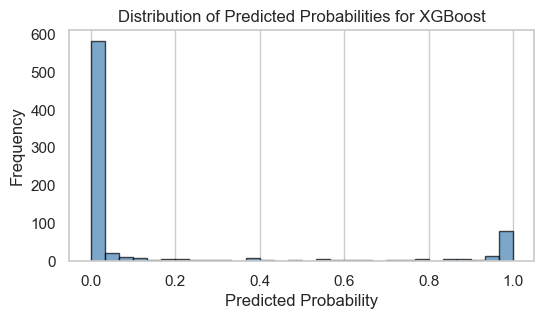

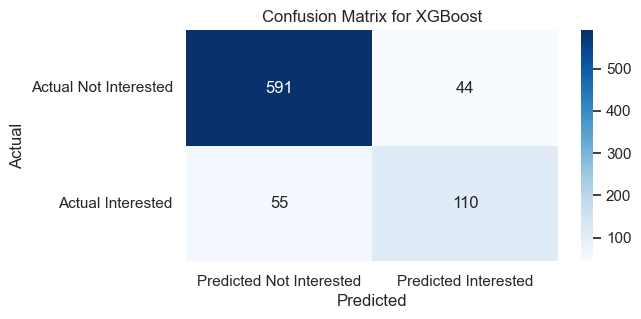

In [393]:
#XGBoost model training

# Prepare the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=1000)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Get predicted probabilities for the validation set
probabilities = xgb_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

# Create a histogram to visualise the predicted probabilities
plt.figure(figsize=(6, 3))
plt.hist(probabilities, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for XGBoost')
plt.grid(axis='y')
plt.show()

# Define a confidence threshold
confidence_threshold = 0.3

# Make predictions based on the defined threshold
y_val_pred = (probabilities >= confidence_threshold).astype(int)

# Compute the confusion matrix and classification report
conf_matrix_xgb = confusion_matrix(y_val, y_val_pred)
class_report_xgb = classification_report(y_val, y_val_pred)

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Interested', 'Predicted Interested'], yticklabels=['Actual Not Interested', 'Actual Interested'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for XGBoost')
plt.show()


# Model Quality Assessment

It appears that LightGBM is the best-performing model for classifying individuals with an interest in subscriptions. In contrast, the distribution of predicted probabilities from the logistic regression model is more uniformly spread, indicating less confidence in its predictions. Meanwhile, the gradient boosting techniques, such as LightGBM, exhibit a bimodal distribution with peaks centred around 0 and 1, suggesting more decisive outcomes with fewer predictions falling in between. Let’s compare the performance metrics for all three models to gain further insights:

In [400]:
# Performance metrics functions 

def display_performance_metrics(confusion_matrix, model_name="Logistic Regression"):
    # Extracting confusion matrix values
    TN, FP, FN, TP = confusion_matrix.ravel()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision_0 = TN / (TN + FN)  # Precision for class 0
    precision_1 = TP / (TP + FP)  # Precision for class 1
    recall_0 = TN / (TN + FP)     # Recall for class 0
    recall_1 = TP / (TP + FN)     # Recall for class 1
    f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
    f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

    # Create a DataFrame for displaying metrics without indices
    metrics_df = pd.DataFrame({
        "Class": ["Not Interested (0)", "Interested (1)"],
        "Precision": [precision_0, precision_1],
        "Recall": [recall_0, recall_1],
        "F1-Score": [f1_score_0, f1_score_1],
        "Accuracy": [accuracy, accuracy]  # Same accuracy for both classes
    }).set_index('Class')  # Set 'Class' as the index to remove default indices

    # Display the title and the metrics table
    display(Markdown(f"#### {model_name}:"))
    display(metrics_df.style.format(precision=2))


In [395]:
# Show performance metrics

display_performance_metrics(conf_matrix_logreg, model_name="Logistic Regression")
display_performance_metrics(conf_matrix_lgbm, model_name="LightGBM")
display_performance_metrics(conf_matrix_xgb, model_name="XGBoost")

#### Logistic Regression:

,Precision,Recall,F1-Score,Accuracy
Class,,,,
Not Interested (0),0.88,0.96,0.92,0.87
Interested (1),0.78,0.52,0.62,0.87


#### LightGBM:

,Precision,Recall,F1-Score,Accuracy
Class,,,,
Not Interested (0),0.93,0.90,0.91,0.87
Interested (1),0.65,0.75,0.70,0.87


#### XGBoost:

,Precision,Recall,F1-Score,Accuracy
Class,,,,
Not Interested (0),0.91,0.93,0.92,0.88
Interested (1),0.71,0.67,0.69,0.88


Considering the objective of this task—identifying potential new clients—the recall for interested individuals (class 1) is of the biggest importance. Recall is defined as the ratio of individuals who are actually interested and are correctly identified as interested by the model.

In this case, the LightGBM model achieved the highest recall of **0.75**. While this indicates that a significant proportion of potential clients were identified, it is worth noting that this result still leaves room for improvement.

There are several potential enhancements to the model that I will discuss in the subsequent sections.

# Findings

I ran the LightGBM model on the test data, producing predicted outputs and the probabilities indicating each person's interest in a long-term gym subscription. Additionally, I will examine the **feature importance** identified by the LightGBM model and analyse the statistics from the test data.

In [405]:
# Predict target values on test dataset
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=200, num_leaves = 35, class_weight='balanced', verbose = -1)
lgb_model.fit(X_train, y_train)

probabilities = lgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Define a confidence threshold, based on the validation set investigation
confidence_threshold = 0.3

# Make predictions based on the defined threshold
y_test_pred = (probabilities >= confidence_threshold).astype(int)


# Create a DataFrame for the output
output_df = pd.DataFrame({
    'user_id': id_test,                   # Ensure this corresponds to your user IDs
    'probability_of_one': probabilities,    # Probability of class 1
    'target': y_test_pred                        # Predicted binary target
})

In [407]:
# Save the predictions to CSV file
output_df.to_csv('test.csv', index=False)

In [408]:
# Show predictions format
display(Markdown('### Predictions on test dataset saved to file in the format:'))
output_df.head()

### Predictions on test dataset saved to file in the format:

,user_id,probability_of_one,target
0,0,0.14,0
1,1,0.64,1
2,2,0.05,0
3,3,0.98,1
4,4,0.01,0


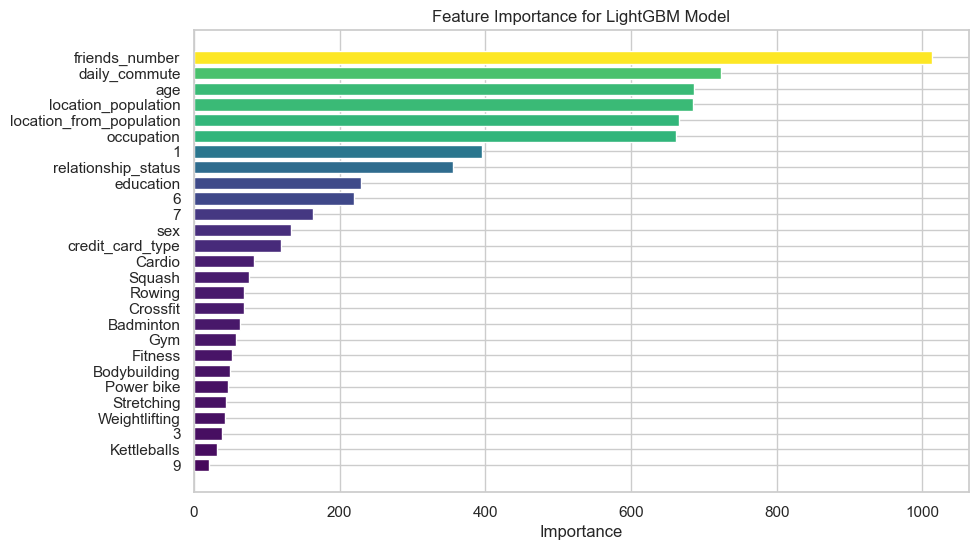

In [409]:
# Retrieve feature importances
importance = lgb_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(feature_importance_df['Importance'] / max(importance))  # Normalize importance for colormap
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance for LightGBM Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [362]:
# Show important groups topics

common_words_per_cluster[common_words_per_cluster['Group Topic'].isin([1, 6, 7])]

,Group Topic,Common Words
1,1,"[looking, rent, join, fans, online]"
6,6,"[group, join, dancing, calse, singles]"
7,7,"[gym, fitness, climbing, bike, excercise]"


### Insights from LightGBM Feature Importance

Interestingly, the number of friends emerged as the most important feature identified by the LightGBM model. Upon reviewing the visualised distributions, we can make several observations:

1. **Daily Commute Distance**: There is a non-linear correlation with gym membership interest.
2. **Age**: Younger individuals, particularly those in the 20-30 age range, are significantly more likely to sign up for a gym membership.
3. **Location Population**: Interest in gym memberships tends to be higher in larger cities, especially those with a population around 1,000,000 people.
4. **Occupation**: Certain occupations are associated with higher interest levels.
5. **Relationship Status**: A notable trend is that single individuals show more interest in gym memberships.
6. **Education**: Different educational backgrounds influence gym membership interest.
7. **Sex**: Gender also plays a role in the likelihood of signing up for a gym.

Additionally, various hobbies are linked to gym membership interest, with notable activities including cardio, squash, rowing, and crossfit. Among the hobby groups, three categories stand out as particularly significant, with their common words detailed above. Notably, the seventh group appears to be strongly connected to sports.

# Limitations of the Approach

1. **Label Encoding of Categorical Variables**:
   - The use of label encoding for categorical variables can lead to misleading representations of the data. Label encoding assigns numerical values to categories but does not capture the ordinal relationships between them. This can result in the model interpreting categorical differences in a linear fashion, which may not reflect the true nature of the categories. Instead, more sophisticated encoding techniques, such as one-hot encoding or target encoding, should be considered to better represent the categorical variables.

2. **Location Strategy**:
   - The current approach to incorporating location data relies heavily on the names of cities and towns. This strategy is inadequate, especially given the presence of numerous small cities and towns where the location name may not carry significant information about potential gym membership interest. A better strategy could involve clustering locations based on demographics or incorporating regional characteristics that affect gym membership, rather than using the raw names of cities.

3. **Feature Selection and Regularization**:
   - Implementing regularization methods, such as Lasso or Ridge regression, could help identify and retain only the most relevant features while reducing the influence of irrelevant ones without completely dropping them.

4. **Data Imputation Techniques**:
   - The handling of missing data through placeholders like 'missing' or '-999' is suboptimal. Such techniques can introduce bias and distort the analysis. Instead, more robust data imputation methods should be employed for both numerical and categorical values. Techniques such as K-nearest neighbors (KNN) imputation or multiple imputation can provide more accurate estimates for missing data.

5. **NLP Techniques for Hobbies Group Clustering**:
   - The current approach to Natural Language Processing (NLP) for clustering hobbies is limited to basic vectorisation and K-means clustering. This methodology overlooks more advanced techniques that can capture semantic meaning, such as word embeddings (Word2Vec, GloVe) or transformer-based models (BERT). Additionally, removing city names from group titles may enhance the clustering process by focusing on the substantive content. Furthermore, the analysis omitted the 'date joined' variable for the hobby groups, which could provide valuable insights into membership trends over time.

6. **Cross-Validation**:
   - Cross-validation is an essential technique for ensuring the robustness and reliability of model evaluations. The current methodology did not implement cross-validation effectively, which may lead to overfitting or underfitting. Adjusting the workflow so that categorical variables are encoded within the cross-validation pipeline will ensure that the model is validated correctly and that the results are generalisable.

7. **Hyperparameter Tuning**:
   - Hyperparameter tuning plays a significant role in optimising model performance. However, the current approach lacks systematic tuning of hyperparameters for each model. Implementing techniques such as grid search or random search within a cross-validation framework will enable the discovery of optimal hyperparameters, resulting in improved model perfor
  
8. **Confidence Threshold**:
   - Confidence Threshold has been set after visualising the distribution of probabilities in the dataset. The initial guess of 0.3 instead of 0.5 gave a better recall on the target value, however, a more precise investigation should be done to optimise the value. mance and accuracy.
bility of our findings.
